In [3]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import psycopg2

pd.options.display.max_columns = 40

## Hack for Heat #3: Number of complaints over time

This time, we're going to look at raw 311 complaint data. The data that I was working with previously was summarized data.

This dataset is much bigger, which is nice because it'll give me a chance to maintain my SQL-querying-from-memory-skills.

First, we're going to have to load all of this data into a postgres database. I wrote [this](http://pew3.com/311schema.txt) tablebase.

## SQL-ing this

The python library [psycopg2](http://initd.org/psycopg/) lets us work with postgres databases in python. We first create a connection object, that encapsulates the connection to the database, then create a cursor class that lets us make queries from that database.

In [22]:
connection = psycopg2.connect('dbname = threeoneone user=threeoneoneadmin password=threeoneoneadmin')
cursor = connection.cursor()

For example, we might want to extract the column names from our table:

In [23]:
cursor.execute('''SELECT * FROM threeoneone.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'service'; ''')
columns = cursor.fetchall()

In [24]:
columns = [x[3] for x in columns]

In [25]:
columns[0:5]

['uniquekey', 'createddate', 'closeddate', 'agency', 'agencyname']

### Complaints over time

Let's start with something simple. First, let's extract a list of all complaints, and the plot the number of complaints by month.

In [27]:
cursor.execute('''SELECT createddate FROM service;''')
complaintdates = cursor.fetchall()

In [32]:
complaintdates = pd.DataFrame(complaintdates)

In [33]:
complaintdates.head()

,0
0,"(2013-04-26,)"
1,"(2013-04-26,)"
2,"(2013-04-26,)"
3,"(2013-04-26,)"
4,"(2013-04-26,)"


Renaming our column:

In [42]:
complaintdates.columns = ['Date']

Next we have to convert these tuples into strings:

In [51]:
complaintdates['Date'] = [x [0] for x in complaintdates['Date']]

Normally, if these were strings, we'd use the extract_dates function we wrote in a previous post. However, because I typed these as datetime objects, we can just extract the .year(), .month(), and .day() attributes:

In [60]:
type(complaintdates['Date'][0])

datetime.date

In [63]:
complaintdates['Day'] = [x.day for x in complaintdates['Date']]
complaintdates['Month'] = [x.month for x in complaintdates['Date']]
complaintdates['Year'] = [x.year for x in complaintdates['Date']]

This is how many total complaints we have:

In [67]:
len(complaintdates)

11371298

We can group them by month:

In [69]:
bymonth = complaintdates.groupby(by='Month').count()
bymonth

,Date,Year,Day
Month,,,
1,1182682,1182682,1182682
2,1065065,1065065,1065065
3,1099983,1099983,1099983
4,985815,985815,985815
5,972913,972913,972913
6,849832,849832,849832
7,875210,875210,875210
8,829573,829573,829573
9,805231,805231,805231


By year:

In [71]:
byyear = complaintdates.groupby(by='Year').count()
byyear

,Date,Month,Day
Year,,,
2010,1754355,1754355,1754355
2011,1688091,1688091,1688091
2012,1568421,1568421,1568421
2013,1614207,1614207,1614207
2014,1839574,1839574,1839574
2015,2021963,2021963,2021963
2016,884687,884687,884687


In [88]:
byday = complaintdates.groupby(by='Day').count()
bydate = complaintdates.groupby(by='Date').count()

### Some matplotlib

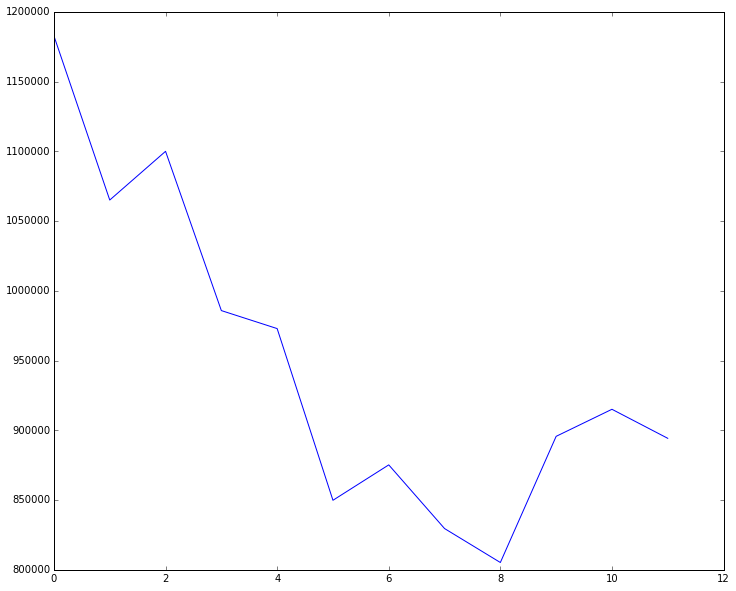

In [70]:
plt.figure(figsize = (12,10))
x = range(0,12)
y = bymonth['Date']
plt.plot(x,y)

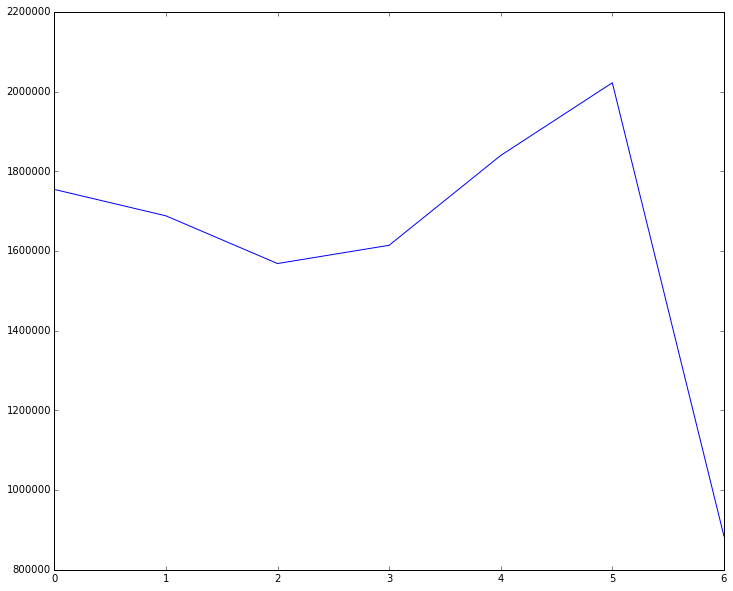

In [78]:
plt.figure(figsize = (12,10))
x = range(0,7)
y = byyear['Date']

plt.plot(x,y)

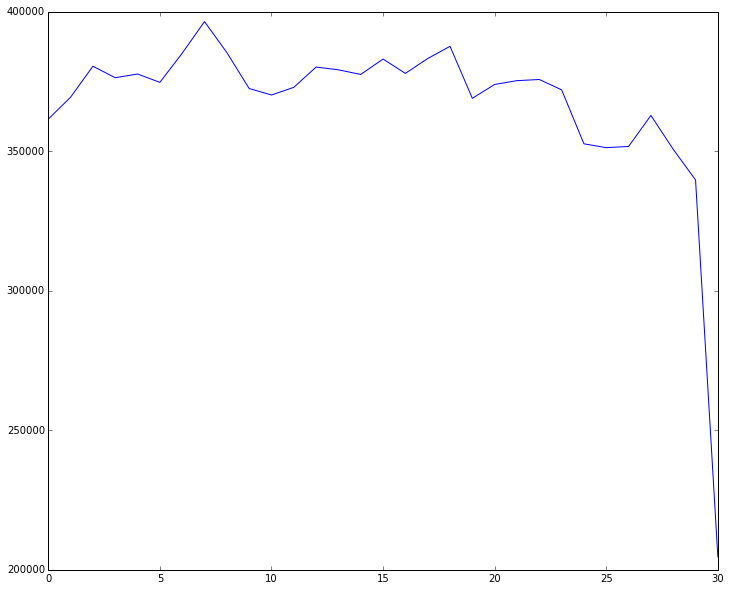

In [86]:
plt.figure(figsize = (12,10))
x = range(0,len(byday))
y = byday['Date']

plt.plot(x,y)

The sharp decline we see at the end is obviously because not all months have the same number of days.

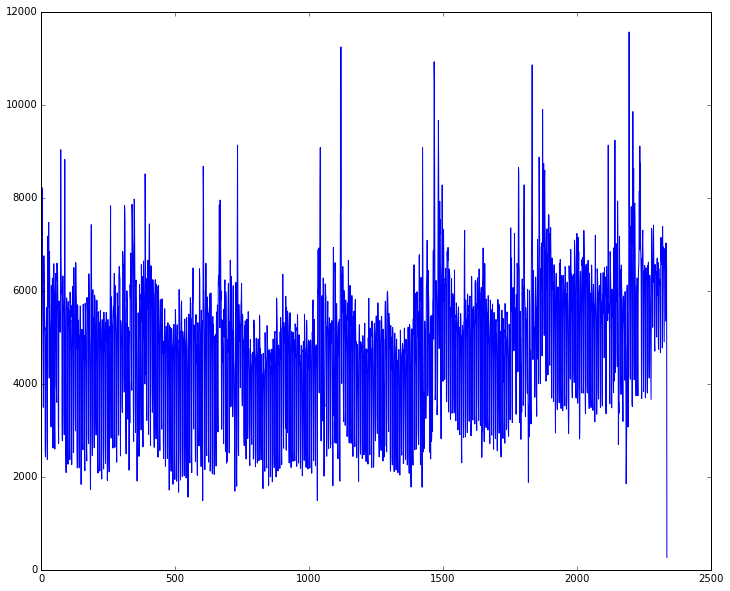

In [94]:
plt.figure(figsize=(12,10))
x = range(0,len(bydate))
y = bydate['Year'] #This is arbitrary - year, month, and day are all series that store the counts

plt.plot(x,y)

That's all for now. In the next post, I'm going to break this down by borough, as well as polish this graph.